# 대회 개요


## 주제
- 공기압축기 이상 판단(제4회 2023 연구개발특구 AI SPARK 챌린지)
- 산업기기 피로도를 예측하는 문제

## 모델 조건
- 모델링은 비지도학습 방식으로 진행
- 입력된 데이터를 정상(0), 이상(1)로 구분하는 이진 분류 모델
- 시간 단위로 생성되는 입력 데이터에 대하여 판정을 수행할 수 있는 모델
- 신규 데이터로 학습/개선이 가능한 모델
- 외부 공공 데이터 사용 가능

## 기타 중요 내용
- 반드시 리더보드상의 순위 기록에 해당되는 버전의 코드/모델 가중치를 제출
- 소스코드 내의 모든 무작위성은 seed 설정을 통해 통제

# 데이터 불러오기

* train_data
    * 학습용 데이터 
    * 모두 정상 case로 이루어짐
    * (2463 * 8)
* test_data
    * 평가용 데이터
    * 정상 case와 이상 case가 함께 포함됨
    * (7389 * 8)

* 구성
    - air_inflow: 공기 흡입 유량 (^3/min)
    - air_end_temp: 공기 말단 온도 (°C)
    - out_pressure: 토출 압력 (Mpa)
    - motor_current: 모터 전류 (A)
    - motor_rpm: 모터 회전수 (rpm)
    - motor_temp: 모터 온도 (°C)
    - motor_vibe: 모터 진동 (mm/s)
    - type: 설비 번호
        - 설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)
        - 설비 번호 1: 20HP
        - 설비 번호 2: 10HP
        - 설비 번호 3: 50HP


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
train_data = pd.read_csv("https://raw.githubusercontent.com/only-juun/AI_spark_challenge/main/train_data.csv")
test_data= pd.read_csv("https://raw.githubusercontent.com/only-juun/AI_spark_challenge/main/test_data.csv")

In [ ]:
train_data.info()

# 데이터 전처리

### motor_vibe 이상치 삭제 및 중복 데이터 제거

In [ ]:
# 중복데이터 144개
train_data = train_data.drop_duplicates()

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2319 entries, 0 to 2462
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     2319 non-null   float64
 1   air_end_temp   2319 non-null   float64
 2   out_pressure   2319 non-null   float64
 3   motor_current  2319 non-null   float64
 4   motor_rpm      2319 non-null   float64
 5   motor_temp     2319 non-null   float64
 6   motor_vibe     2319 non-null   float64
 7   type           2319 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 163.1 KB


In [ ]:
# 20HP 에서 motor_vibe값이 이상치로 판단되는 행 제거: 16개
train_data = train_data.loc[train_data['motor_vibe'] < 20.0, :]

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2303 entries, 0 to 2462
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     2303 non-null   float64
 1   air_end_temp   2303 non-null   float64
 2   out_pressure   2303 non-null   float64
 3   motor_current  2303 non-null   float64
 4   motor_rpm      2303 non-null   float64
 5   motor_temp     2303 non-null   float64
 6   motor_vibe     2303 non-null   float64
 7   type           2303 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 161.9 KB


### 데이터 증강

In [ ]:
temp_0 = train_data.loc[train_data['type'] == 0, :]
temp_1 = train_data.loc[train_data['type'] == 1, :]
temp_2 = train_data.loc[train_data['type'] == 2, :]
temp_3 = train_data.loc[train_data['type'] == 3, :]
temp_4 = train_data.loc[train_data['type'] == 4, :]
temp_5 = train_data.loc[train_data['type'] == 5, :]
temp_6 = train_data.loc[train_data['type'] == 6, :]
temp_7 = train_data.loc[train_data['type'] == 7, :]

In [ ]:
# from sklearn.cluster import KMeans
# from sklearn.manifold import TSNE

# def cluster_based_augmentation(train_data, num_new_data=10000, n_clusters=10):
#     # Feature 선택
#     X = train_data[['air_inflow', 'air_end_temp', 'out_pressure', 'motor_current', 'motor_rpm', 'motor_temp', 'motor_vibe', 'type']]

#     # KMeans 알고리즘을 이용하여 데이터를 클러스터링합니다.
#     kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42).fit(X)

#     # 클러스터링 결과 중심점을 centroids에 저장합니다.
#     centroids = kmeans.cluster_centers_

#     # 각 클러스터의 개수를 저장합니다.
#     cluster_sizes = np.bincount(kmeans.labels_)

#     # 각 클러스터에서 t-SNE를 이용하여 2차원으로 축소한 데이터를 생성합니다.
#     tsne = TSNE(n_components=2, perplexity=30, random_state=42)
#     X_tsne = tsne.fit_transform(X)
#     new_data_tsne = []
#     for i, centroid in enumerate(centroids):
#         # 해당 클러스터에 속하는 데이터를 추출합니다.
#         cluster_data = X_tsne[kmeans.labels_ == i]
#         # 해당 클러스터의 중심점을 중심으로 한 가우시안 분포를 생성합니다.
#         mean, std = cluster_data.mean(axis=0), cluster_data.std(axis=0)
#         # 해당 클러스터에서 새로운 데이터를 생성합니다.
#         new_cluster_data = np.random.normal(loc=mean, scale=std, size=(int(num_new_data * cluster_sizes[i] / len(X)), 2))
#         new_data_tsne.append(new_cluster_data)

#     # 생성된 새로운 데이터를 데이터프레임으로 변환합니다.
#     new_data = np.concatenate(new_data_tsne, axis=0)
#     # new_data = tsne.inverse_transform(new_data)
#     new_data = pd.DataFrame(new_data, columns=X.columns)

#     # 기존 데이터와 생성된 데이터를 합쳐서 최종 데이터프레임을 생성합니다.
#     final_data = pd.concat([train_data, new_data], ignore_index=True)

#     return final_data

from sklearn.cluster import KMeans

def cluster_based_augmentation(train_data, num_new_data=10000, n_clusters=7):
    # Feature 선택
    X = train_data[['air_inflow', 'air_end_temp', 'out_pressure', 'motor_current', 'motor_rpm', 'motor_temp', 'motor_vibe', 'type']]

    # KMeans 알고리즘을 이용하여 데이터를 클러스터링합니다.
    kmeans = KMeans(n_clusters=n_clusters, n_init=10000, random_state=42).fit(X)

    # 클러스터링 결과 중심점을 centroids에 저장합니다.
    centroids = kmeans.cluster_centers_

    # 각 클러스터의 개수를 저장합니다.
    cluster_sizes = np.bincount(kmeans.labels_)

    # 새로운 데이터를 저장할 빈 리스트를 생성합니다.
    new_data = []

    # 각 클러스터의 중심점을 이용하여 새로운 데이터를 생성합니다.
    for i, centroid in enumerate(centroids):
        for j in range(int(num_new_data * cluster_sizes[i] / len(X))):
            # 중심점 주변에 임의의 값으로 노이즈를 추가합니다.
            new_point = centroid + np.random.normal(scale=0.1, size=len(centroid))
            new_data.append(new_point)

    # 생성된 새로운 데이터를 데이터프레임으로 변환합니다.
    new_data = pd.DataFrame(new_data, columns=X.columns)

    # 기존 데이터와 생성된 데이터를 합쳐서 최종 데이터프레임을 생성합니다.
    final_data = pd.concat([train_data, new_data], ignore_index=True)

    return final_data

In [ ]:
new_temp_0 = cluster_based_augmentation(temp_0, num_new_data=1700, n_clusters=7)
new_temp_1 = cluster_based_augmentation(temp_1)
new_temp_2 = cluster_based_augmentation(temp_2)
new_temp_3 = cluster_based_augmentation(temp_3)
new_temp_4 = cluster_based_augmentation(temp_4, num_new_data=1700, n_clusters=7)
new_temp_5 = cluster_based_augmentation(temp_5, num_new_data=1700, n_clusters=7)
new_temp_6 = cluster_based_augmentation(temp_6, num_new_data=1700, n_clusters=7)
new_temp_7 = cluster_based_augmentation(temp_7, num_new_data=1700, n_clusters=7)
new_temp_0['type'] = 0
new_temp_1['type'] = 1
new_temp_2['type'] = 2
new_temp_3['type'] = 3
new_temp_4['type'] = 4
new_temp_5['type'] = 5
new_temp_6['type'] = 6
new_temp_7['type'] = 7

final_data = pd.concat([new_temp_0, new_temp_1, new_temp_2, new_temp_3, new_temp_4, new_temp_5, new_temp_6, new_temp_7], ignore_index=True)
final_data['out_pressure'] = 0.7

In [ ]:
mapping_dict = {
    2: 10,
    1: 20,
    0: 30,
    4: 30, 
    5: 30,
    6: 30,
    7: 30,
    3: 50,
}

final_data['hp'] = final_data['type'].map(mapping_dict)
test_data['hp'] = test_data['type'].map(mapping_dict)

### type -> hp(Horse Power)
    * type: 설비 번호
        - 설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)
        - 설비 번호 1: 20HP
        - 설비 번호 2: 10HP
        - 설비 번호 3: 50HP

In [ ]:
mapping_dict = {
    2: 10,
    1: 20,
    0: 30,
    4: 30, 
    5: 30,
    6: 30,
    7: 30,
    3: 50,
}

train_data['hp'] = train_data['type'].map(mapping_dict)
test_data['hp'] = test_data['type'].map(mapping_dict)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     2463 non-null   float64
 1   air_end_temp   2463 non-null   float64
 2   out_pressure   2463 non-null   float64
 3   motor_current  2463 non-null   float64
 4   motor_rpm      2463 non-null   float64
 5   motor_temp     2463 non-null   float64
 6   motor_vibe     2463 non-null   float64
 7   type           2463 non-null   int64  
 8   hp             2463 non-null   int64  
dtypes: float64(7), int64(2)
memory usage: 173.3 KB


### 새로운 Feature 추가하기

In [ ]:
# 모터 전류 당 공기 유량은 압축기의 효율성
final_data['air_inflow_per_motor_current'] = final_data['air_inflow'] / final_data['motor_current']	
test_data['air_inflow_per_motor_current'] = test_data['air_inflow'] / test_data['motor_current']

# 압축기와 모터의 상태를 모두 고려한 압축기 효율1
final_data['Compressor_Efficiency1'] = final_data['out_pressure'] * final_data['air_inflow'] / final_data['motor_current'] / 3.5168 / final_data['hp']
test_data['Compressor_Efficiency1'] = test_data['out_pressure'] * test_data['air_inflow'] / test_data['motor_current'] / 3.5168 / test_data['hp']

# 압축기와 모터의 상태를 모두 고려한 압축기 효율2
final_data['Motor_Efficiency'] = (final_data['motor_current'] * final_data['motor_rpm'] * final_data['hp']) / (746 * 1000)
test_data['Motor_Efficiency'] = (test_data['motor_current'] * test_data['motor_rpm'] * test_data['hp']) / (746 * 1000)

# 압축기의 효율2
final_data['Compressor_Efficiency2'] = (final_data['out_pressure'] * final_data['air_inflow'] * (final_data['air_end_temp'] - 25)) / (final_data['motor_current'] * final_data['motor_vibe'] * final_data['hp'] * 3.6)
test_data['Compressor_Efficiency2'] = (test_data['out_pressure'] * test_data['air_inflow'] * (test_data['air_end_temp'] - 25)) / (test_data['motor_current'] * test_data['motor_vibe'] * test_data['hp'] * 3.6)

# 압축기의 배출량
final_data['Discharge_Volume'] = (final_data['air_inflow'] / 60) * ((final_data['air_end_temp'] + 273) / 273) * (final_data['out_pressure'] / 1.01325)
test_data['Discharge_Volume'] = (test_data['air_inflow'] / 60) * ((test_data['air_end_temp'] + 273) / 273) * (test_data['out_pressure'] / 1.01325)

# 공기의 밀도
final_data['air_density'] = final_data['out_pressure'] / (287 * (final_data['air_end_temp'] + 273))
test_data['air_density'] = test_data['out_pressure'] / (287 * (test_data['air_end_temp'] + 273))

In [ ]:
# 모터 전류 당 공기 유량은 압축기의 효율성
train_data['air_inflow_per_motor_current'] = train_data['air_inflow'] / train_data['motor_current']	
test_data['air_inflow_per_motor_current'] = test_data['air_inflow'] / test_data['motor_current']

# 압축기와 모터의 상태를 모두 고려한 압축기 효율1
train_data['Compressor_Efficiency1'] = train_data['out_pressure'] * train_data['air_inflow'] / train_data['motor_current'] / 3.5168 / train_data['hp']
test_data['Compressor_Efficiency1'] = test_data['out_pressure'] * test_data['air_inflow'] / test_data['motor_current'] / 3.5168 / test_data['hp']

# 압축기와 모터의 상태를 모두 고려한 압축기 효율2
train_data['Motor_Efficiency'] = (train_data['motor_current'] * train_data['motor_rpm'] * train_data['hp']) / (746 * 1000)
test_data['Motor_Efficiency'] = (test_data['motor_current'] * test_data['motor_rpm'] * test_data['hp']) / (746 * 1000)

# 압축기의 효율2
train_data['Compressor_Efficiency2'] = (train_data['out_pressure'] * train_data['air_inflow'] * (train_data['air_end_temp'] - 25)) / (train_data['motor_current'] * train_data['motor_vibe'] * train_data['hp'] * 3.6)
test_data['Compressor_Efficiency2'] = (test_data['out_pressure'] * test_data['air_inflow'] * (test_data['air_end_temp'] - 25)) / (test_data['motor_current'] * test_data['motor_vibe'] * test_data['hp'] * 3.6)

# 압축기의 배출량
train_data['Discharge_Volume'] = (train_data['air_inflow'] / 60) * ((train_data['air_end_temp'] + 273) / 273) * (train_data['out_pressure'] / 1.01325)
test_data['Discharge_Volume'] = (test_data['air_inflow'] / 60) * ((test_data['air_end_temp'] + 273) / 273) * (test_data['out_pressure'] / 1.01325)

# 공기의 밀도
train_data['air_density'] = train_data['out_pressure'] / (287 * (train_data['air_end_temp'] + 273))
test_data['air_density'] = test_data['out_pressure'] / (287 * (test_data['air_end_temp'] + 273))

In [ ]:
# from sklearn.utils import shuffle

# final_data=shuffle(final_data)

# 데이터 분석

## Pandas-profiling

In [ ]:
# !pip install pandas-profiling[notebook]

In [ ]:
from pandas_profiling import ProfileReport

In [ ]:
x_10 = final_data.loc[final_data['hp'] == 10, :]
# x_20 = final_data.loc[final_data['hp'] == 20, :]
# x_30 = final_data.loc[final_data['hp'] == 30, :]
# x_50 = final_data.loc[final_data['hp'] == 50, :]


x_10_profile = ProfileReport(x_10)
x_10_profile.to_file(f"x_10_report(new).html")

# x_20_profile = ProfileReport(x_20)
# x_20_profile.to_file(f"x_20_report(new).html")

# x_30_profile = ProfileReport(x_30)
# x_30_profile.to_file(f"x_30_report(new).html")

# x_50_profile = ProfileReport(x_50)
# x_50_profile.to_file(f"x_50_report(new).html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# pandas-profiling 보고서 생성
train_data_profile = ProfileReport(train_data)
train_data_profile.to_file(f"train_data_report(new).html")

test_data_profile = ProfileReport(test_data)
test_data_profile.to_file(f"test_data_report(new).html")

## ydata-profiling(pandas-profiling과 거의 동일함)

In [ ]:
# !pip install ydata-profiling

In [ ]:
# from ydata_profiling import ProfileReport

In [ ]:
# train_profile = ProfileReport(train_data, title="Profiling Report")
# train_profile.to_file("train_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# test_profile = ProfileReport(test_data, title="Profiling Report")
# test_profile.to_file("test_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Sweetviz

In [ ]:
!pip install sweetviz

In [ ]:
import sweetviz as sv

In [ ]:
train_data_report = sv.analyze(train_data)
train_data_report.show_html("sweetviz_train_data.html")

test_data_report = sv.analyze(test_data)
test_data_report.show_html("sweetviz_test_data.html")

                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_train_data.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_test_data.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## AutoViz

In [ ]:
!pip install autoviz --upgrade

In [ ]:
from autoviz.AutoViz_Class import AutoViz_Class

# AutoViz 인스턴스 생성
AV = AutoViz_Class()

In [ ]:
train_url = "https://raw.githubusercontent.com/only-juun/AI_spark_challenge/main/train_data.csv"
dft = AV.AutoViz(train_url, chart_format="html", verbose = 0)

In [ ]:
test_url = "https://raw.githubusercontent.com/only-juun/AI_spark_challenge/main/test_data.csv"
dft = AV.AutoViz(test_url, chart_format="html")

## D-Tale

In [ ]:
!pip install dtale

In [ ]:
import dtale

In [ ]:
import dtale.app as dtale_app
# https://github.com/man-group/dtale#google-colab
dtale_app.USE_COLAB = True

In [ ]:
dtale.show(train_data)

https://rylqcpjcsnc-496ff2e9c6d22116-40000-colab.googleusercontent.com/dtale/main/3

In [ ]:
dtale.show(test_data)

https://rylqcpjcsnc-496ff2e9c6d22116-40000-colab.googleusercontent.com/dtale/main/4

# 모델링

### AutoEncoder_default

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import EarlyStopping

model_name = 'ae_aug_ninit10000_val001'

# Preprocess the data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(final_data)
test_data_scaled = scaler.transform(test_data)

# Define the autoencoder architecture
input_dim = train_data_scaled.shape[1]
encoding_dim = 64
hidden_dim = 32

encoder = tf.keras.Sequential([
    tf.keras.layers.Dense(encoding_dim, activation='relu', input_shape=(input_dim,)),
    tf.keras.layers.Dense(hidden_dim, activation='relu')
])

decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(encoding_dim, activation='relu', input_shape=(hidden_dim,)),
    tf.keras.layers.Dense(input_dim, activation='linear')
])

ae_default = tf.keras.Sequential([encoder, decoder])

# Compile and train the autoencoder with early stopping
ae_default.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
history = ae_default.fit(train_data_scaled, train_data_scaled, epochs=10000, batch_size=32, validation_split=0.01, callbacks=[early_stopping], verbose=1)
ae_default.save(f"{model_name}.h5")

Epoch 1/10000
1262/1262 [==============================] - 10s 3ms/step - loss: 0.0256 - val_loss: 5.7841e-04
Epoch 2/10000
1262/1262 [==============================] - 4s 3ms/step - loss: 4.0976e-04 - val_loss: 2.9028e-04
Epoch 3/10000
1262/1262 [==============================] - 3s 3ms/step - loss: 2.5242e-04 - val_loss: 2.0983e-04
Epoch 4/10000
1262/1262 [==============================] - 3s 3ms/step - loss: 2.0629e-04 - val_loss: 2.3269e-04
Epoch 5/10000
1262/1262 [==============================] - 4s 3ms/step - loss: 1.8453e-04 - val_loss: 1.0399e-04
Epoch 6/10000
1262/1262 [==============================] - 3s 3ms/step - loss: 1.7144e-04 - val_loss: 1.2647e-04
Epoch 7/10000
1262/1262 [==============================] - 3s 3ms/step - loss: 1.3413e-04 - val_loss: 1.4792e-04
Epoch 8/10000
1262/1262 [==============================] - 4s 3ms/step - loss: 1.3080e-04 - val_loss: 1.4191e-04
Epoch 9/10000
1262/1262 [==============================] - 3s 3ms/step - loss: 1.3004e-04 - val_los

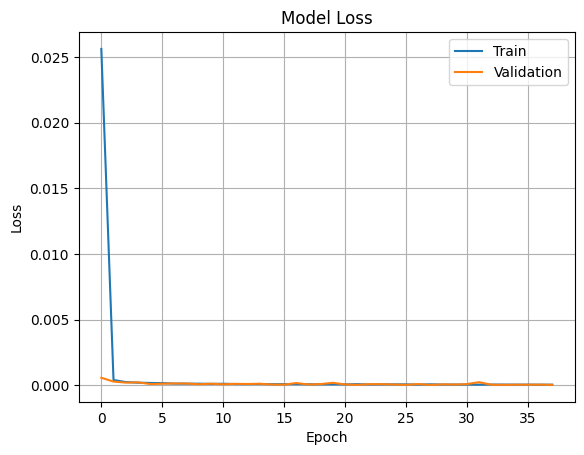

In [ ]:
 # 모델 학습 과정 시각화
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 학습된 모델 로드
model = tf.keras.models.load_model(f"{model_name}.h5")

# Calculate the reconstruction error for test_data
test_data_reconstructed = model.predict(test_data_scaled)
reconstruction_error = np.mean(np.square(test_data_scaled - test_data_reconstructed), axis=1)

# Set a threshold for considering a test point as an anomaly
threshold = np.percentile(reconstruction_error, 95.34)
threshold2 = np.percentile(reconstruction_error, 95.35)
threshold3 = np.percentile(reconstruction_error, 95.38)

# Predict anomalies in test_data
prediction = (reconstruction_error > threshold).astype(int)
prediction2 = (reconstruction_error > threshold2).astype(int)
prediction3 = (reconstruction_error > threshold3).astype(int)

231/231 [==============================] - 0s 1ms/step


# Feature Importance 확인

motor_temp: 1.61
type: 1.36
motor_current: 1.33
motor_rpm: 1.33
air_density: 1.32
Discharge_Volume: 1.30
motor_vibe: 1.29
out_pressure: 1.28
air_end_temp: 1.28
Compressor_Efficiency1: 1.28
Motor_Efficiency: 1.26
air_inflow: 1.26
hp: 1.21
Compressor_Efficiency2: 1.18
air_inflow_per_motor_current: 1.06


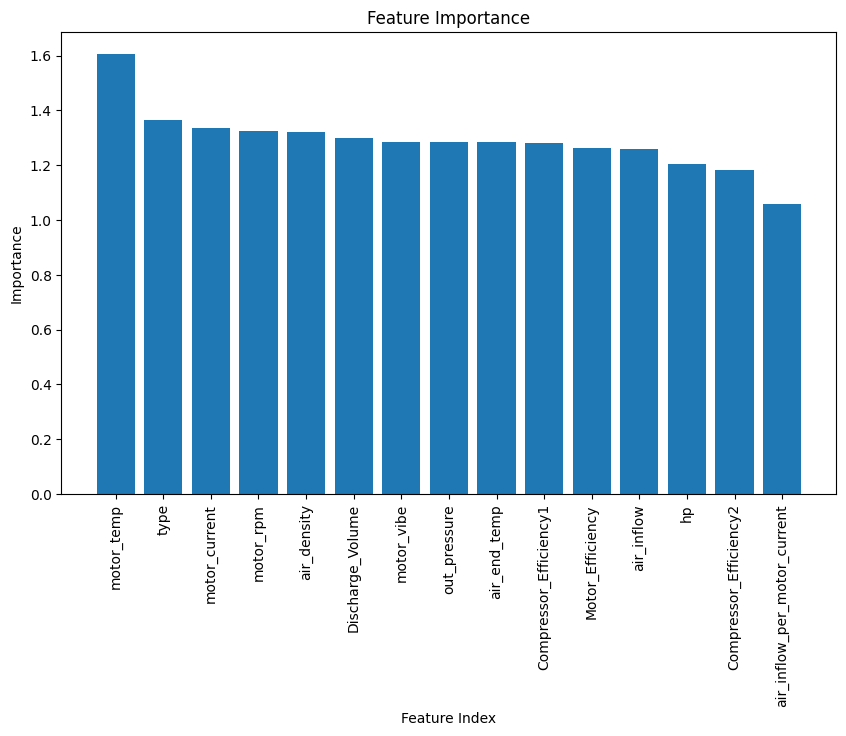

In [ ]:
import matplotlib.pyplot as plt

columns = final_data.columns

# Extract encoder layer and weights
encoder_layer = model.layers[0]
weights = encoder_layer.get_weights()[0]

# Calculate feature importance as the L2 norm of weights
feature_importance = np.linalg.norm(weights, axis=1)

# Sort feature importance in descending order
sorted_importance_indices = np.argsort(feature_importance)[::-1]
sorted_importance = feature_importance[sorted_importance_indices]

# Print sorted feature importance
for i in range(len(sorted_importance)):
    print('{}: {:.2f}'.format(columns[sorted_importance_indices[i]], sorted_importance[i]))

# Create bar chart of sorted feature importance
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(sorted_importance)), sorted_importance)
ax.set_title('Feature Importance')
ax.set_xlabel('Feature Index')
ax.set_ylabel('Importance')
ax.set_xticks(range(len(sorted_importance)))
ax.set_xticklabels(columns[sorted_importance_indices])
plt.xticks(rotation=90)
plt.show()

# 데이터 저장

In [ ]:
from collections import Counter

count = Counter(prediction2)
num_0 = count[0]
num_1 = count[1]

print("Number of 0s: ", num_0)
print("Number of 1s: ", num_1)

Number of 0s:  7045
Number of 1s:  344


In [ ]:
cnt = 0
for a, b in zip(prediction1, prediction2):
    if a != b:
        cnt +=1
print(cnt)

12


In [ ]:
file_name = model_name + '_th35_shuffle'

In [ ]:
# 코랩에 저장
idx = test_data.loc[:, 'type']
y_pred = {'type': idx, 'label': prediction2}
test_prediction = pd.DataFrame(y_pred)
test_prediction.to_csv(f"{file_name}.csv")

In [ ]:
# 구글드라이브에 저장(연동 필요요)
idx = test_data.loc[:, 'type']
y_pred = {'type': idx, 'label': prediction}
test_prediction = pd.DataFrame(y_pred)
test_prediction.to_csv(f"/content/drive/MyDrive/AIFactory/dataset/{file_name}.csv")